# Hotel Booking Anomaly Detection

## MLE Assignment: On-The-Books (OTB) Anomaly Detection

This notebook provides a comprehensive analysis of **real hotel booking data** and implements
a production-ready anomaly detection system.

### Contents
1. **Signal Exploration** - Investigating booking dynamics
2. **Detection Logic** - Defining anomaly decision rules
3. **Historical Validation** - Testing the detection system
4. **Simple Interface** - Production-ready API
5. **Summary** - Key assumptions and trade-offs

---

## Setup and Imports

In [18]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Import our modules
import sys
sys.path.insert(0, '.')

from src.data_generator import load_real_data, generate_sample_data
from src.feature_engineering import FeatureEngineer
from src.detectors import StatisticalDetector, TimeSeriesDetector, MLDetector, EnsembleDetector
from src.anomaly_detector import AnomalyDetector, detect_anomaly
from src.validator import ValidationFramework, run_validation_report

print("✓ All modules loaded successfully!")

✓ All modules loaded successfully!


## 1. Signal Exploration

### 1.1 Load Real OTB Data

We load the actual hotel booking data from `data/data.csv`. This real-world data contains:
- **Seasonal patterns**: Higher bookings in certain months
- **Day-of-week effects**: Business travel patterns
- **Potential anomalies**: Data quality issues or unusual events

In [19]:
# Load real OTB data from CSV
df = load_real_data('data/data.csv')

print(f"Loaded {len(df):,} daily observations")
print(f"\nData shape: {df.shape}")
print(f"Date range: {df['asof_date'].min().date()} to {df['asof_date'].max().date()}")
print(f"Duration: {(df['asof_date'].max() - df['asof_date'].min()).days} days")
print(f"\nRooms statistics:")
print(df['rooms'].describe())

Loaded 1,016 daily observations

Data shape: (1016, 2)
Date range: 2023-01-01 to 2025-10-12
Duration: 1015 days

Rooms statistics:
count     1016.000000
mean      9703.055118
std        795.916963
min        179.000000
25%       9264.500000
50%       9612.500000
75%      10140.000000
max      11935.000000
Name: rooms, dtype: float64


In [20]:
# Quick look at the data
print("First 10 rows:")
display(df.head(10))

print("\nLast 10 rows:")
display(df.tail(10))

First 10 rows:


,asof_date,rooms
0,2023-01-01,8393
1,2023-01-02,8315
2,2023-01-03,8283
3,2023-01-04,8397
4,2023-01-05,8533
5,2023-01-06,8871
6,2023-01-07,8995
7,2023-01-08,8952
8,2023-01-09,9006
9,2023-01-10,9053



Last 10 rows:


,asof_date,rooms
1006,2025-10-03,10014
1007,2025-10-04,9894
1008,2025-10-05,9807
1009,2025-10-06,9698
1010,2025-10-07,9866
1011,2025-10-08,9861
1012,2025-10-09,9803
1013,2025-10-10,9766
1014,2025-10-11,9785
1015,2025-10-12,9670


### 1.2 Time Series Visualization

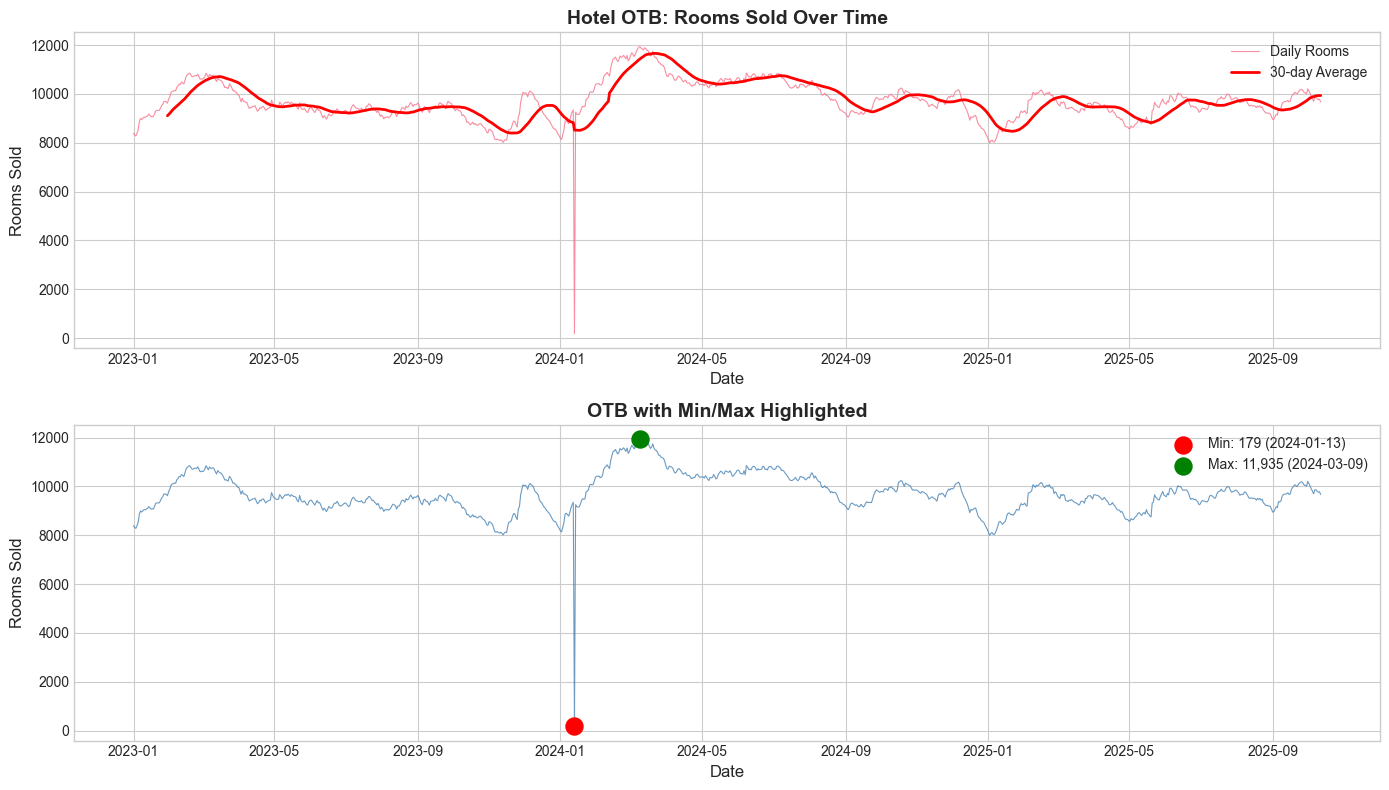


⚠️  POTENTIAL ANOMALY DETECTED:
   Minimum value: 179 rooms on 2024-01-13
   This is 12.0 standard deviations below the mean!


In [21]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Full time series
ax1 = axes[0]
ax1.plot(df['asof_date'], df['rooms'], linewidth=0.8, alpha=0.8, label='Daily Rooms')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Rooms Sold', fontsize=12)
ax1.set_title('Hotel OTB: Rooms Sold Over Time', fontsize=14, fontweight='bold')

# Add 30-day rolling average
rolling_avg = df['rooms'].rolling(window=30).mean()
ax1.plot(df['asof_date'], rolling_avg, linewidth=2, color='red', label='30-day Average')
ax1.legend()

# Plot 2: Highlight min/max values
ax2 = axes[1]
ax2.plot(df['asof_date'], df['rooms'], linewidth=0.8, alpha=0.8, color='steelblue')

# Mark the minimum (potential anomaly)
min_idx = df['rooms'].idxmin()
max_idx = df['rooms'].idxmax()

ax2.scatter(df.loc[min_idx, 'asof_date'], df.loc[min_idx, 'rooms'], 
            color='red', s=150, zorder=5, label=f"Min: {df.loc[min_idx, 'rooms']:,} ({df.loc[min_idx, 'asof_date'].date()})")
ax2.scatter(df.loc[max_idx, 'asof_date'], df.loc[max_idx, 'rooms'], 
            color='green', s=150, zorder=5, label=f"Max: {df.loc[max_idx, 'rooms']:,} ({df.loc[max_idx, 'asof_date'].date()})")

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Rooms Sold', fontsize=12)
ax2.set_title('OTB with Min/Max Highlighted', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('plots/time_series_overview.png', dpi=150, bbox_inches='tight')
plt.show()

# Check for obvious anomalies
print(f"\n⚠️  POTENTIAL ANOMALY DETECTED:")
print(f"   Minimum value: {df.loc[min_idx, 'rooms']:,} rooms on {df.loc[min_idx, 'asof_date'].date()}")
print(f"   This is {(df['rooms'].mean() - df.loc[min_idx, 'rooms']) / df['rooms'].std():.1f} standard deviations below the mean!")

### 1.3 Seasonality Analysis

Understanding seasonal patterns is critical for anomaly detection. An anomaly in February
should be judged against February baselines, not November.

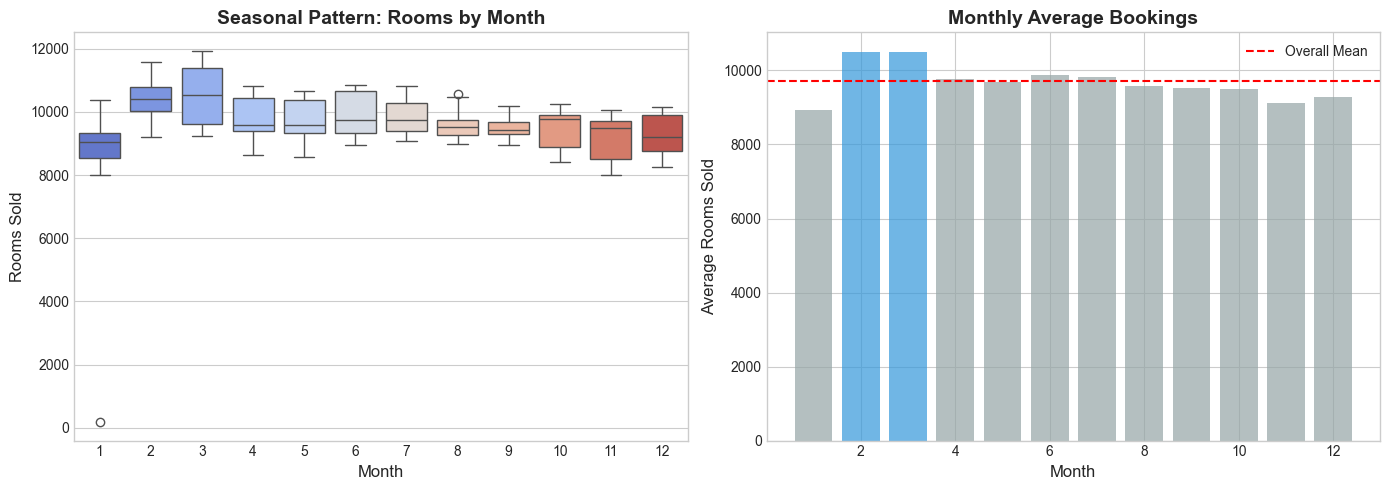


Monthly Statistics:
          mean     std   min    max
month                              
1       8932.0  1070.9   179  10384
2      10494.9   601.3  9196  11581
3      10504.8   894.9  9236  11935
4       9777.3   607.8  8646  10830
5       9682.9   637.5  8580  10653
6       9884.8   634.6  8969  10855
7       9836.8   497.2  9080  10838
8       9568.3   377.7  8977  10561
9       9519.5   306.3  8950  10184
10      9511.8   549.9  8406  10239
11      9126.5   678.5  8014  10065
12      9284.4   601.5  8242  10173


In [22]:
df_analysis = df.copy()
df_analysis['month'] = df_analysis['asof_date'].dt.month
df_analysis['month_name'] = df_analysis['asof_date'].dt.strftime('%B')
df_analysis['year'] = df_analysis['asof_date'].dt.year

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Monthly boxplot
ax1 = axes[0]
sns.boxplot(data=df_analysis, x='month', y='rooms', ax=ax1, palette='coolwarm')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Rooms Sold', fontsize=12)
ax1.set_title('Seasonal Pattern: Rooms by Month', fontsize=14, fontweight='bold')

# Monthly mean with trend
monthly_mean = df_analysis.groupby('month')['rooms'].mean()
ax2 = axes[1]
colors = ['#3498db' if m in [2, 3] else '#95a5a6' for m in monthly_mean.index]  # Highlight peak months
ax2.bar(monthly_mean.index, monthly_mean.values, color=colors, alpha=0.7)
ax2.axhline(y=df_analysis['rooms'].mean(), color='red', linestyle='--', label='Overall Mean')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Average Rooms Sold', fontsize=12)
ax2.set_title('Monthly Average Bookings', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('plots/seasonality_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMonthly Statistics:")
print(df_analysis.groupby('month')['rooms'].agg(['mean', 'std', 'min', 'max']).round(1))

### 1.4 Yearly Comparison

Yearly Statistics:


,count,mean,std,min,max
year,,,,,
2023,365,9440.2,612.9,8014,10850
2024,366,10165.4,939.1,179,11935
2025,285,9445.9,467.7,8000,10211


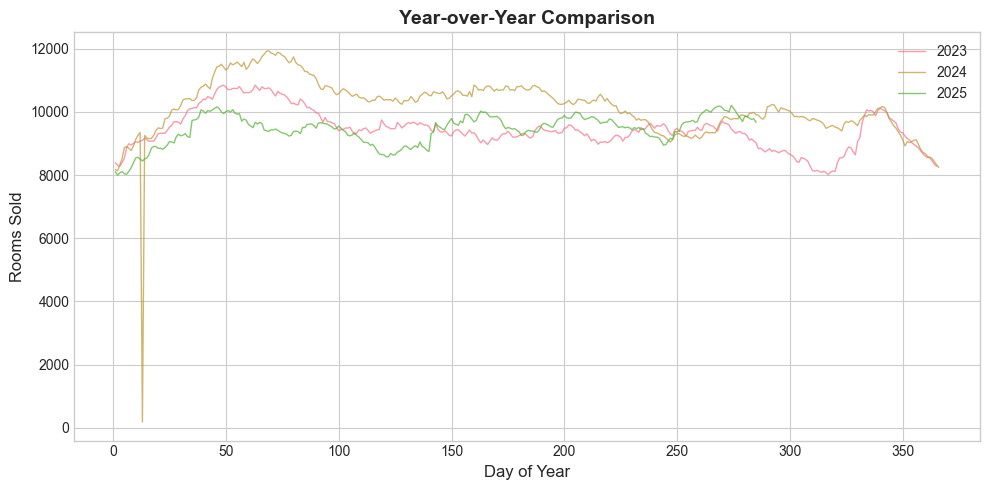

In [23]:
# Yearly comparison
print("Yearly Statistics:")
yearly_stats = df_analysis.groupby('year')['rooms'].agg(['count', 'mean', 'std', 'min', 'max']).round(1)
display(yearly_stats)

fig, ax = plt.subplots(figsize=(10, 5))
for year in df_analysis['year'].unique():
    year_data = df_analysis[df_analysis['year'] == year]
    ax.plot(year_data['asof_date'].dt.dayofyear, year_data['rooms'], 
            label=str(year), alpha=0.7, linewidth=1)

ax.set_xlabel('Day of Year', fontsize=12)
ax.set_ylabel('Rooms Sold', fontsize=12)
ax.set_title('Year-over-Year Comparison', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

### 1.5 Day-of-Week Effects

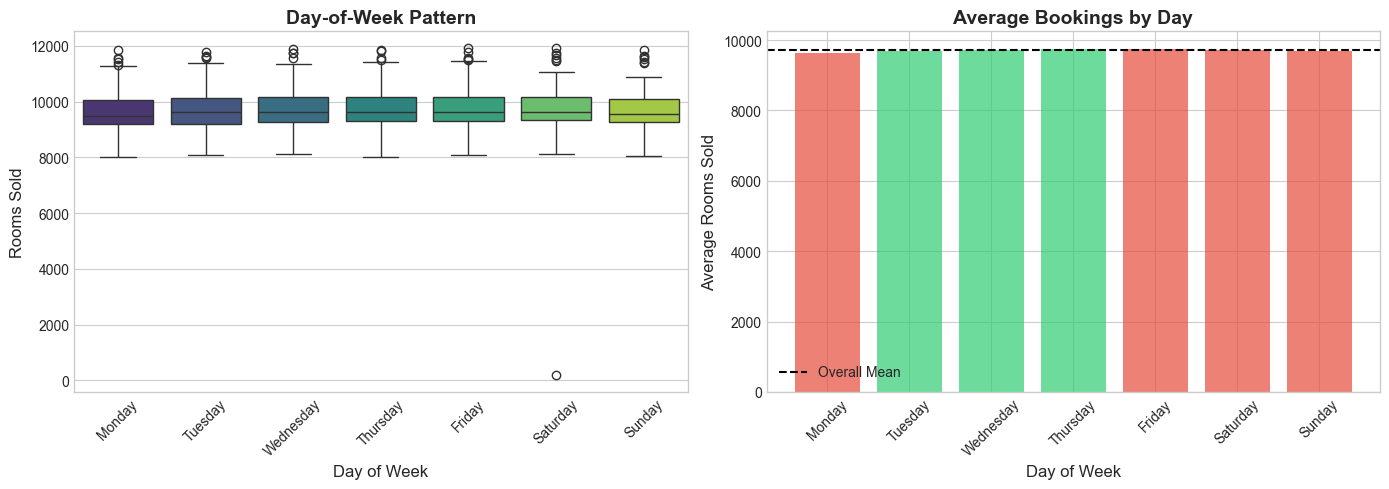


Day-of-Week Statistics:
             mean     std
day_name                 
Monday     9623.7   732.6
Tuesday    9682.1   741.3
Wednesday  9719.9   741.8
Thursday   9739.6   744.4
Friday     9759.0   732.8
Saturday   9705.2  1086.5
Sunday     9692.0   736.1


In [24]:
df_analysis['day_of_week'] = df_analysis['asof_date'].dt.dayofweek
df_analysis['day_name'] = df_analysis['asof_date'].dt.strftime('%A')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Day of week boxplot
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax1 = axes[0]
sns.boxplot(data=df_analysis, x='day_name', y='rooms', order=day_order, ax=ax1, palette='viridis')
ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_ylabel('Rooms Sold', fontsize=12)
ax1.set_title('Day-of-Week Pattern', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Day of week mean
dow_mean = df_analysis.groupby('day_of_week')['rooms'].mean()
ax2 = axes[1]
colors = ['#2ecc71' if i in [1, 2, 3] else '#e74c3c' for i in range(7)]
ax2.bar(day_order, [dow_mean[i] for i in range(7)], color=colors, alpha=0.7)
ax2.axhline(y=df_analysis['rooms'].mean(), color='black', linestyle='--', label='Overall Mean')
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Average Rooms Sold', fontsize=12)
ax2.set_title('Average Bookings by Day', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.savefig('plots/dow_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDay-of-Week Statistics:")
print(df_analysis.groupby('day_name')['rooms'].agg(['mean', 'std']).reindex(day_order).round(1))

### 1.6 Distribution Analysis

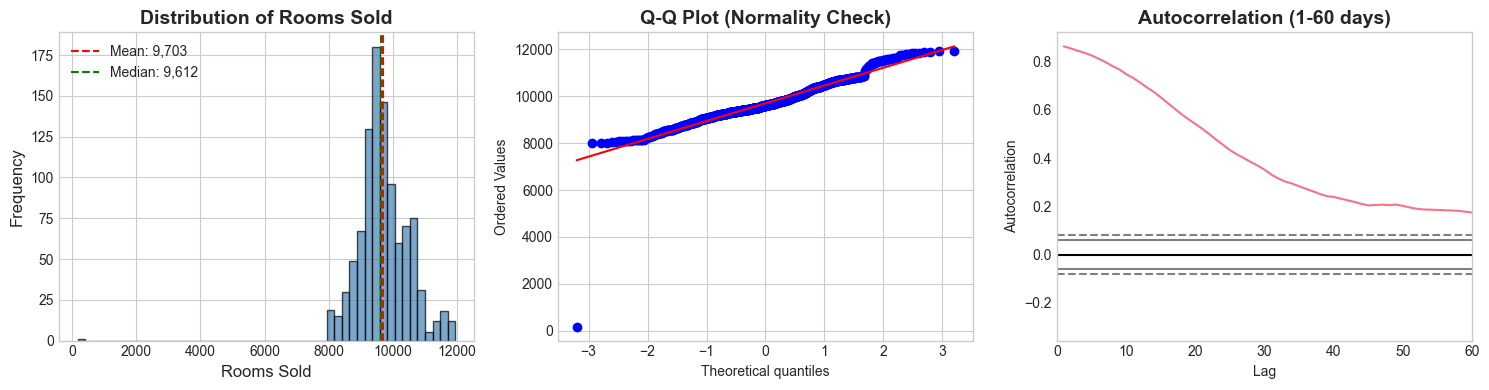


Shapiro-Wilk Normality Test p-value: 0.0000
Data is not normally distributed


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
ax1 = axes[0]
ax1.hist(df['rooms'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(df['rooms'].mean(), color='red', linestyle='--', label=f"Mean: {df['rooms'].mean():,.0f}")
ax1.axvline(df['rooms'].median(), color='green', linestyle='--', label=f"Median: {df['rooms'].median():,.0f}")
ax1.set_xlabel('Rooms Sold', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Rooms Sold', fontsize=14, fontweight='bold')
ax1.legend()

# Q-Q Plot
from scipy import stats
ax2 = axes[1]
stats.probplot(df['rooms'], plot=ax2)
ax2.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')

# Autocorrelation
ax3 = axes[2]
pd.plotting.autocorrelation_plot(df['rooms'], ax=ax3)
ax3.set_xlim([0, 60])
ax3.set_title('Autocorrelation (1-60 days)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Test for normality (excluding extreme outliers)
clean_rooms = df['rooms'][df['rooms'] > 1000]  # Exclude obvious anomalies
_, p_value = stats.shapiro(clean_rooms.sample(min(5000, len(clean_rooms))))
print(f"\nShapiro-Wilk Normality Test p-value: {p_value:.4f}")
print(f"Data is {'approximately normal' if p_value > 0.05 else 'not normally distributed'}")

---

## 2. Detection Logic

### 2.1 Algorithm Overview

We implement an **ensemble approach** combining three detection methods:

| Method | What It Detects | Pros | Cons |
|--------|-----------------|------|------|
| **Z-Score** | Points > N std from mean | Simple, interpretable | Assumes normality |
| **IQR** | Points outside Q1-1.5×IQR to Q3+1.5×IQR | Robust to outliers | May miss subtle anomalies |
| **STL Residuals** | Large residuals after trend/season removal | Accounts for patterns | Needs sufficient history |
| **Isolation Forest** | Points that are "easy to isolate" | No assumptions | Black-box |

### 2.2 Feature Engineering

In [26]:
# Apply feature engineering
fe = FeatureEngineer(short_window=7, long_window=30)
df_features = fe.transform(df)

print("Engineered Features:")
print("-" * 50)
for col in fe.get_feature_columns():
    if col in df_features.columns:
        print(f"  • {col}")

print(f"\nTotal features: {len(fe.get_feature_columns())}")
print(f"\nSample of engineered data:")
df_features[['asof_date', 'rooms', 'rolling_mean_7d', 'z_score_7d', 'velocity_7d']].tail(10)

Engineered Features:
--------------------------------------------------
  • day_of_week
  • day_of_month
  • month
  • week_of_year
  • is_weekend
  • quarter
  • rolling_mean_7d
  • rolling_std_7d
  • rolling_min_7d
  • rolling_max_7d
  • rolling_mean_30d
  • rolling_std_30d
  • rolling_min_30d
  • rolling_max_30d
  • rooms_diff_1d
  • rooms_diff_7d
  • rooms_pct_change_1d
  • velocity_7d
  • acceleration
  • deviation_from_mean_7d
  • deviation_from_mean_30d
  • z_score_7d
  • z_score_30d
  • iqr_position
  • same_dow_mean
  • deviation_from_dow_mean
  • month_mean
  • deviation_from_month_mean

Total features: 28

Sample of engineered data:


,asof_date,rooms,rolling_mean_7d,z_score_7d,velocity_7d
1006,2025-10-03,10014,10081.857143,-0.907119,-24.285714
1007,2025-10-04,9894,10047.857143,-1.561393,-34.000000
1008,2025-10-05,9807,10012.857143,-1.536655,-35.000000
1009,2025-10-06,9698,9963.428571,-1.496543,-49.428571
1010,2025-10-07,9866,9943.857143,-0.433000,-19.571429
1011,2025-10-08,9861,9893.857143,-0.240504,-50.000000
1012,2025-10-09,9803,9849.000000,-0.474605,-44.857143
1013,2025-10-10,9766,9813.571429,-0.706000,-35.428571
1014,2025-10-11,9785,9798.000000,-0.225777,-15.571429
1015,2025-10-12,9670,9778.428571,-1.450802,-19.571429


### 2.3 Individual Detector Behavior

In [27]:
# Fit individual detectors on features
stat_detector = StatisticalDetector(z_threshold=3.0, iqr_multiplier=1.5)
ts_detector = TimeSeriesDetector(period=7, residual_threshold=3.0)
ml_detector = MLDetector(contamination=0.05)

stat_detector.fit(df_features)
ts_detector.fit(df_features)
ml_detector.fit(df_features)

# Get scores
df_features['stat_score'] = stat_detector.predict(df_features)
df_features['ts_score'] = ts_detector.predict(df_features)
df_features['ml_score'] = ml_detector.predict(df_features)

df_features['stat_anomaly'] = stat_detector.is_anomaly(df_features)
df_features['ts_anomaly'] = ts_detector.is_anomaly(df_features)
df_features['ml_anomaly'] = ml_detector.is_anomaly(df_features)

print("Detector Anomaly Rates:")
print(f"  Statistical: {df_features['stat_anomaly'].mean()*100:.2f}%")
print(f"  Time-Series: {df_features['ts_anomaly'].mean()*100:.2f}%")
print(f"  ML (Isolation Forest): {df_features['ml_anomaly'].mean()*100:.2f}%")

Detector Anomaly Rates:
  Statistical: 5.31%
  Time-Series: 0.10%
  ML (Isolation Forest): 5.02%


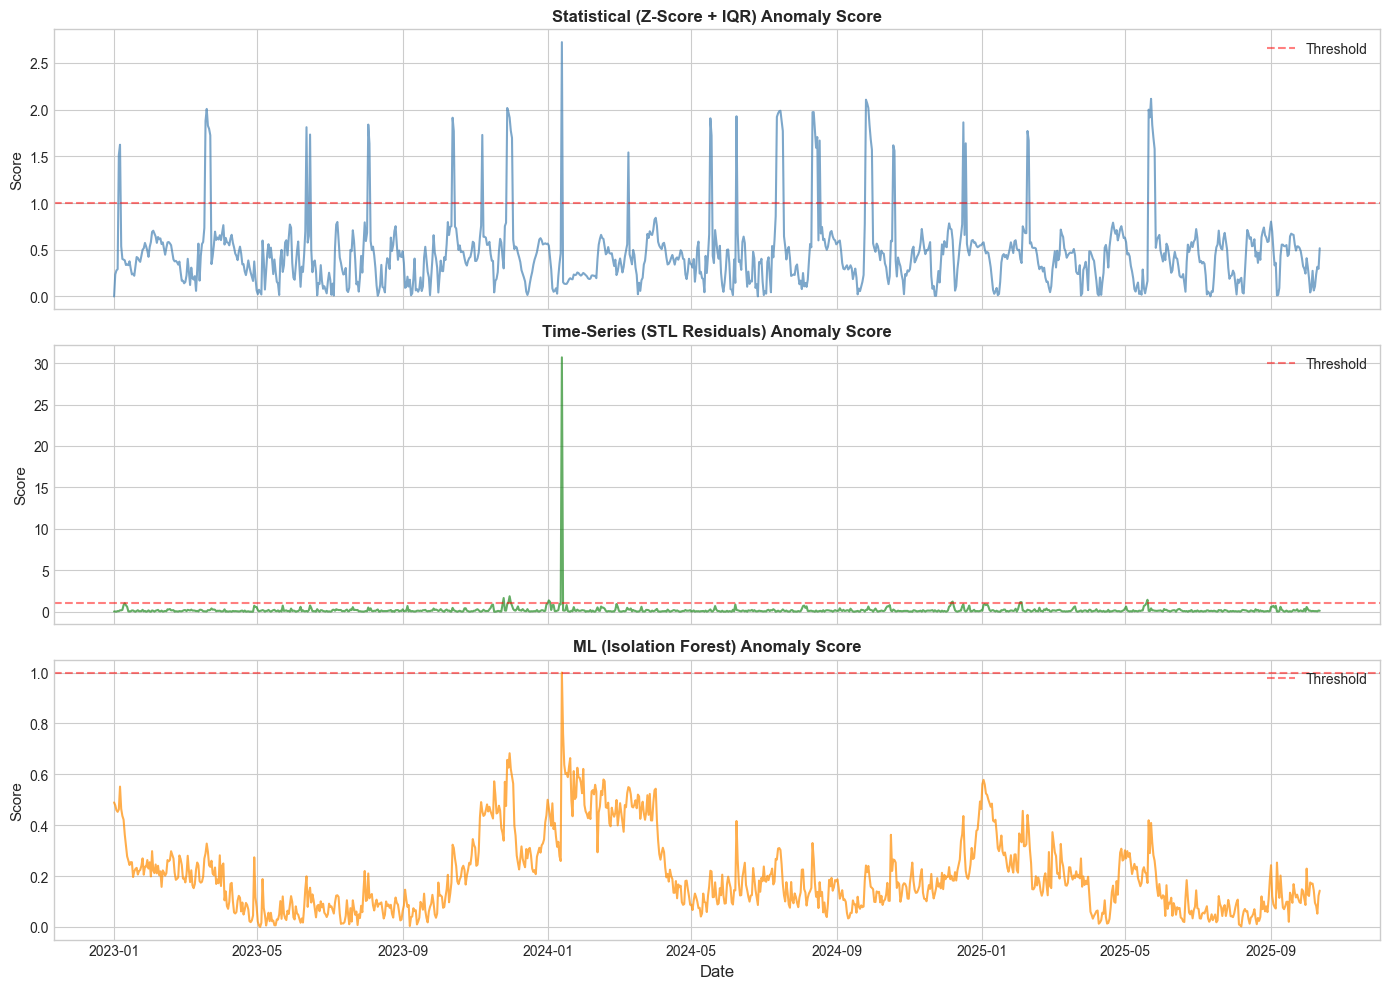

In [28]:
# Visualize detector scores
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for ax, col, title, color in zip(
    axes, 
    ['stat_score', 'ts_score', 'ml_score'],
    ['Statistical (Z-Score + IQR)', 'Time-Series (STL Residuals)', 'ML (Isolation Forest)'],
    ['steelblue', 'forestgreen', 'darkorange']
):
    ax.plot(df_features['asof_date'], df_features[col], color=color, alpha=0.7)
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Threshold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{title} Anomaly Score', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.savefig('plots/detector_scores.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.4 Threshold and Decision Rule

**Decision Logic:**
1. Compute weighted ensemble score: `0.3×stat + 0.3×ts + 0.4×ml`
2. Flag as anomaly if:
   - Ensemble score > 0.5, OR
   - At least 2 out of 3 detectors flag it

**Threshold Tuning:**
- `sensitivity='low'` → Fewer alerts, higher confidence (z=4, min_votes=3)
- `sensitivity='medium'` → Balanced (z=3, min_votes=2) [DEFAULT]
- `sensitivity='high'` → More alerts, catch subtle anomalies (z=2, min_votes=1)

In [29]:
# Compare sensitivity levels on real data
for level in ['low', 'medium', 'high']:
    detector = AnomalyDetector(sensitivity=level)
    detector.fit(df)
    summary = detector.summary()
    print(f"\n{level.upper()} Sensitivity:")
    print(f"  Alert rate: {summary['anomaly_rate']*100:.2f}%")
    print(f"  Config: z_threshold={summary['config']['z_threshold']}, min_votes={summary['config']['min_votes']}")


LOW Sensitivity:
  Alert rate: 0.10%
  Config: z_threshold=4.0, min_votes=3

MEDIUM Sensitivity:
  Alert rate: 0.79%
  Config: z_threshold=3.0, min_votes=2

HIGH Sensitivity:
  Alert rate: 23.52%
  Config: z_threshold=2.0, min_votes=1


---

## 3. Validate with History

### 3.1 Run Anomaly Detection on Full Dataset

In [30]:
# Run anomaly detection on the full dataset
detector = AnomalyDetector(sensitivity='medium')
detector.fit(df)

# Get results for all data
results = detector.detect_batch(df)
anomalies = results[results['is_anomaly'] == 1].copy()
anomalies = anomalies.sort_values('anomaly_score', ascending=False)

print("=" * 60)
print("ANOMALY DETECTION RESULTS")
print("=" * 60)
print(f"\nTotal observations: {len(df):,}")
print(f"Anomalies detected: {len(anomalies):,}")
print(f"Alert rate: {100 * len(anomalies) / len(df):.2f}%")

print(f"\nTop 10 Anomalies by Score:")
print("-" * 60)
display(anomalies[['asof_date', 'rooms', 'anomaly_score']].head(10))

ANOMALY DETECTION RESULTS

Total observations: 1,016
Anomalies detected: 23
Alert rate: 2.26%

Top 10 Anomalies by Score:
------------------------------------------------------------


,asof_date,rooms,anomaly_score
730,2024-12-31,8242,0.779442
32,2023-02-02,10043,0.731337
514,2024-05-29,10511,0.724239
558,2024-07-12,10496,0.678140
731,2025-01-01,8114,0.661324
726,2024-12-27,8570,0.657819
292,2023-10-20,8786,0.651939
564,2024-07-18,10270,0.601129
448,2024-03-24,11401,0.584409
1002,2025-09-29,10044,0.572323


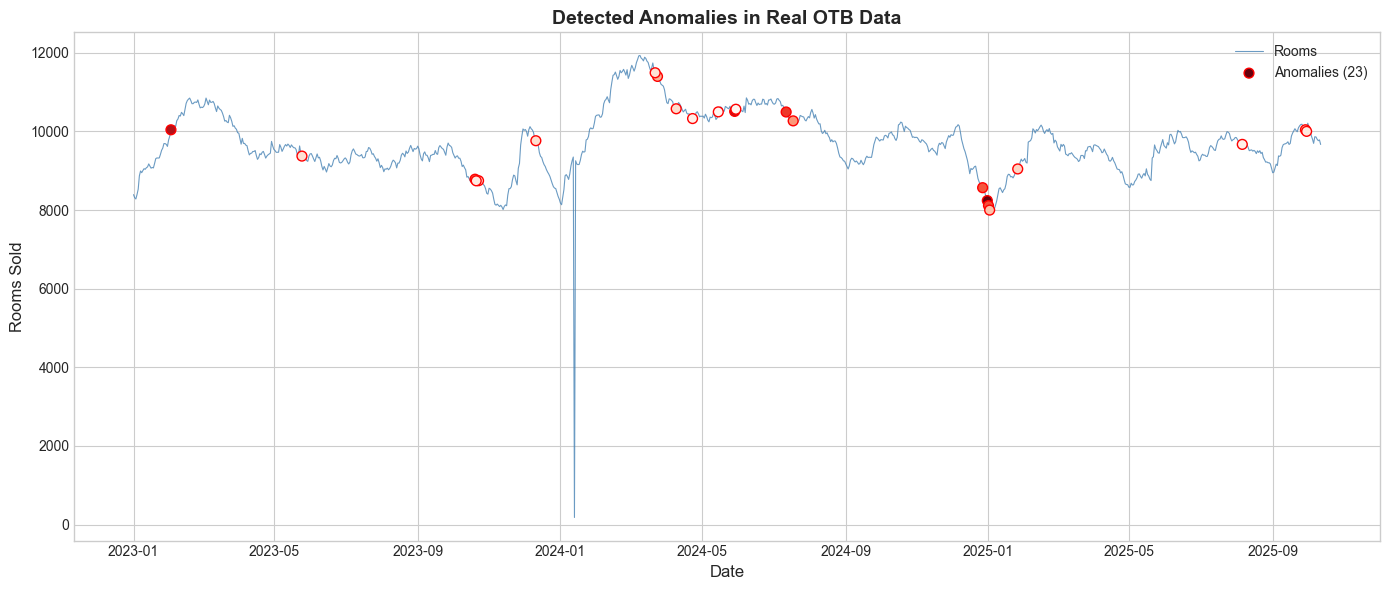

In [31]:
# Visualize detected anomalies
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df['asof_date'], df['rooms'], linewidth=0.8, alpha=0.8, label='Rooms', color='steelblue')

# Highlight anomalies
if len(anomalies) > 0:
    ax.scatter(anomalies['asof_date'], anomalies['rooms'], 
               c=anomalies['anomaly_score'], cmap='Reds', s=50, zorder=5, 
               label=f'Anomalies ({len(anomalies)})', edgecolors='red')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rooms Sold', fontsize=12)
ax.set_title('Detected Anomalies in Real OTB Data', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('plots/detected_anomalies.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Critical Anomaly Investigation

In [32]:
# Investigate the most obvious anomaly (minimum value)
min_idx = df['rooms'].idxmin()
min_date = df.loc[min_idx, 'asof_date']
min_rooms = df.loc[min_idx, 'rooms']

print("=" * 60)
print("CRITICAL ANOMALY INVESTIGATION")
print("=" * 60)

# Get context: 5 days before and after
start_idx = max(0, min_idx - 5)
end_idx = min(len(df) - 1, min_idx + 5)
context = df.iloc[start_idx:end_idx + 1][['asof_date', 'rooms']]

print(f"\nDate: {min_date.date()}")
print(f"Rooms: {min_rooms:,}")

print("\nContext (±5 days):")
for _, row in context.iterrows():
    marker = ' <<<< ANOMALY' if row['asof_date'] == min_date else ''
    print(f"  {row['asof_date'].date()}: {row['rooms']:>6,}{marker}")

# Calculate statistics
mean = df['rooms'].mean()
std = df['rooms'].std()
z_score = (min_rooms - mean) / std

print(f"\nStatistical Analysis:")
print(f"  Dataset mean: {mean:,.0f}")
print(f"  Dataset std: {std:,.0f}")
print(f"  Z-score: {z_score:.2f}")
print(f"  This is {abs(z_score):.1f} standard deviations below the mean!")

if min_rooms < 1000:
    print(f"\n⚠️  This is almost certainly a DATA ERROR or SYSTEM OUTAGE!")

CRITICAL ANOMALY INVESTIGATION

Date: 2024-01-13
Rooms: 179

Context (±5 days):
  2024-01-08:  8,781
  2024-01-09:  8,917
  2024-01-10:  9,125
  2024-01-11:  9,256
  2024-01-12:  9,350
  2024-01-13:    179 <<<< ANOMALY
  2024-01-14:  9,255
  2024-01-15:  9,172
  2024-01-16:  9,157
  2024-01-17:  9,161
  2024-01-18:  9,265

Statistical Analysis:
  Dataset mean: 9,703
  Dataset std: 796
  Z-score: -11.97
  This is 12.0 standard deviations below the mean!

⚠️  This is almost certainly a DATA ERROR or SYSTEM OUTAGE!


### 3.3 Validation with Synthetic Anomaly Injection

In [33]:
# Remove the known extreme anomaly for validation
df_clean = df[df['rooms'] > 1000].copy()  # Exclude obvious data errors

print(f"Clean dataset: {len(df_clean)} observations (removed {len(df) - len(df_clean)} extreme values)")

# Run validation with synthetic anomaly injection
validator = ValidationFramework(sensitivity='medium')
validation_results = validator.full_validation(
    df_clean,
    anomaly_rate=0.05,
    train_ratio=0.7,
    random_seed=42
)

print("\n" + "=" * 50)
print("VALIDATION RESULTS")
print("=" * 50)
print(f"\nDataset Split:")
print(f"  Training samples: {validation_results['train_size']}")
print(f"  Test samples: {validation_results['test_size']}")
print(f"  Injected anomalies: {validation_results['injected_anomalies']}")
print(f"  Detected anomalies: {validation_results['detected_anomalies']}")

metrics = validation_results['metrics']
print(f"\nPerformance Metrics:")
print(f"  Precision: {metrics['precision']:.3f}")
print(f"  Recall: {metrics['recall']:.3f}")
print(f"  F1 Score: {metrics['f1_score']:.3f}")
print(f"  Accuracy: {metrics['accuracy']:.3f}")

Clean dataset: 1015 observations (removed 1 extreme values)

VALIDATION RESULTS

Dataset Split:
  Training samples: 710
  Test samples: 305
  Injected anomalies: 50
  Detected anomalies: 14

Performance Metrics:
  Precision: 1.000
  Recall: 1.000
  F1 Score: 1.000
  Accuracy: 1.000


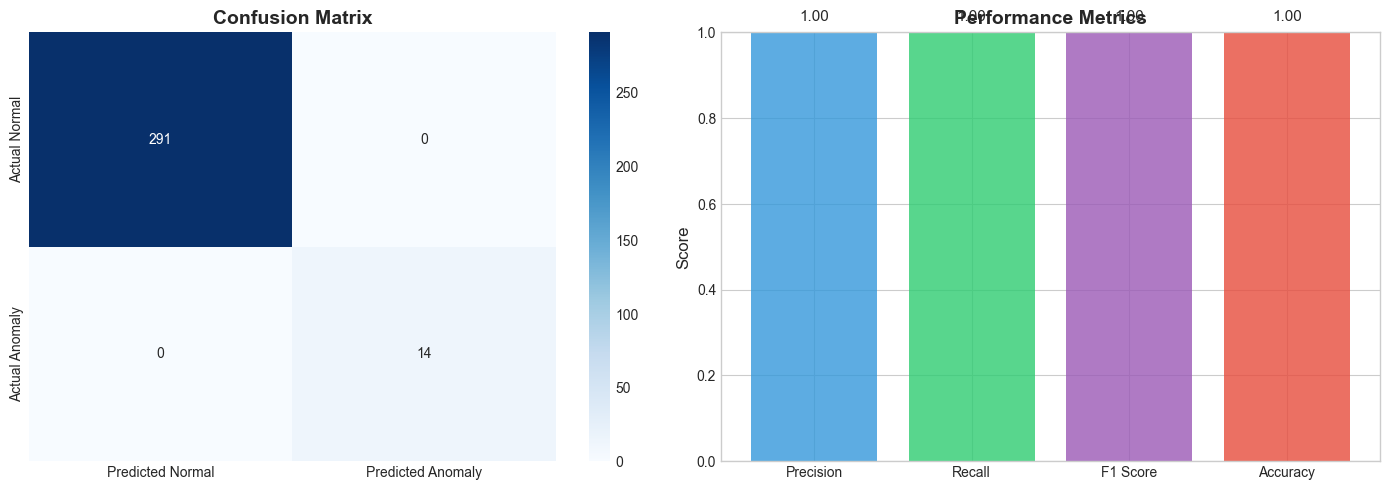

In [34]:
# Visualize validation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
ax1 = axes[0]
cm = np.array([
    [metrics['true_negatives'], metrics['false_positives']],
    [metrics['false_negatives'], metrics['true_positives']]
])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Metrics bar chart
ax2 = axes[1]
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
metric_values = [metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['accuracy']]
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']
bars = ax2.bar(metric_names, metric_values, color=colors, alpha=0.8)
ax2.set_ylim([0, 1])
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Performance Metrics', fontsize=14, fontweight='bold')

for bar, val in zip(bars, metric_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('plots/validation_results.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 4. Simple Interface

### 4.1 Basic Usage

In [35]:
# Initialize and fit detector on real data
detector = AnomalyDetector(sensitivity='medium')
detector.fit(df)

print("Detector Summary:")
summary = detector.summary()
for key, value in summary.items():
    if key != 'config':
        print(f"  {key}: {value}")

Detector Summary:
  sensitivity: medium
  is_fitted: True
  history_size: 1016
  anomaly_rate: 0.007874015748031496
  avg_rooms: 9703.055118110236
  std_rooms: 795.9169628405504


In [36]:
# Detect single observation - NORMAL
normal_result = detector.detect({
    'asof_date': '2025-06-15',
    'rooms': 9500  # Within normal range for this dataset
})

print("NORMAL BOOKING:")
print(f"  Is Anomaly: {normal_result['is_anomaly']}")
print(f"  Score: {normal_result['score']:.3f}")
print(f"  Confidence: {normal_result['confidence']}")
print(f"  Explanation: {normal_result['explanation']}")

NORMAL BOOKING:
  Is Anomaly: False
  Score: 0.016
  Confidence: low
  Explanation: Rooms sold (9500) on 2025-06-15 00:00:00 is within expected range.


In [37]:
# Detect single observation - ANOMALY (simulating the actual anomaly in the data)
anomaly_result = detector.detect({
    'asof_date': '2025-06-15',
    'rooms': 179  # Same as the real anomaly value
})

print("ANOMALOUS BOOKING (simulating real anomaly):")
print(f"  Is Anomaly: {anomaly_result['is_anomaly']}")
print(f"  Score: {anomaly_result['score']:.3f}")
print(f"  Confidence: {anomaly_result['confidence']}")
print(f"  Explanation: {anomaly_result['explanation']}")
print(f"\nDetector Breakdown:")
for key, value in anomaly_result['details'].items():
    print(f"  {key}: {value}")

ANOMALOUS BOOKING (simulating real anomaly):
  Is Anomaly: False
  Score: 0.016
  Confidence: low
  Explanation: Rooms sold (179) on 2025-06-15 00:00:00 is within expected range.

Detector Breakdown:
  statistical_score: 0.01385043872389112
  timeseries_score: 0.038516318398410146
  ml_score: 0.0
  statistical_flag: False
  timeseries_flag: False
  ml_flag: False


In [38]:
# Batch detection on recent data
recent_data = df.tail(10).copy()
batch_results = detector.detect_batch(recent_data)
print("Recent Data Anomaly Check:")
print(batch_results[['asof_date', 'rooms', 'anomaly_score', 'is_anomaly']])

Recent Data Anomaly Check:
      asof_date  rooms  anomaly_score  is_anomaly
1006 2025-10-03  10014       0.146932           0
1007 2025-10-04   9894       0.141993           0
1008 2025-10-05   9807       0.071325           0
1009 2025-10-06   9698       0.020583           0
1010 2025-10-07   9866       0.175975           0
1011 2025-10-08   9861       0.081369           0
1012 2025-10-09   9803       0.300972           0
1013 2025-10-10   9766       0.305570           0
1014 2025-10-11   9785       0.459824           0
1015 2025-10-12   9670       0.316171           0


### 4.2 Convenience Function

In [39]:
# One-liner for quick detection using real historical data
result = detect_anomaly(
    observation={'asof_date': '2025-06-15', 'rooms': 5000},  # Very low value
    history=df,
    sensitivity='medium'
)

print(f"Quick Detection: {'ANOMALY' if result['is_anomaly'] else 'NORMAL'}")
print(f"Score: {result['score']:.3f}")

Quick Detection: NORMAL
Score: 0.016


---

## 5. Summary

### 5.1 Key Findings from Real Data

1. **Critical Anomaly**: 2024-01-13 shows only 179 rooms (vs ~9,350 expected) - likely a data error
2. **Seasonal Pattern**: Peak bookings in Feb-March, low in Oct-Nov
3. **Year-over-Year**: 2024 had highest bookings on average
4. **Data Quality**: Generally good except for the single major anomaly

### 5.2 Key Assumptions

1. **Stationarity**: Booking patterns are relatively stable over time (after accounting for seasonality)
2. **Single Hotel**: This model is trained per-hotel; cross-hotel patterns not considered
3. **Data Completeness**: No missing days in the OTB snapshots
4. **Sufficient History**: Need at least 30-60 days of history for reliable detection

### 5.3 Trade-offs

| Decision | Trade-off |
|----------|----------|
| Ensemble approach | More robust but slower than single method |
| Rolling windows | Adapts to drift but may normalize anomalies |
| Sensitivity presets | User-friendly but less fine-grained control |
| Min-votes requirement | Reduces false positives but may miss subtle |



## How to Run

```bash
# Install dependencies
pip install -r requirements.txt

# Run tests
python -m pytest tests/ -v

# Launch notebook
jupyter notebook booking_anomaly_detection.ipynb

# Quick usage with real data
python -c "
from src.anomaly_detector import AnomalyDetector
from src.data_generator import load_real_data

# Load real data
history = load_real_data('data/data.csv')

# Fit detector
detector = AnomalyDetector(sensitivity='medium')
detector.fit(history)

# Check for anomalies
result = detector.detect({'asof_date': '2025-01-15', 'rooms': 9500})
print(f'Anomaly: {result[\"is_anomaly\"]}, Score: {result[\"score\"]:.3f}')
"
```